In [1]:
# --- PHASE 1: MOUNT GOOGLE DRIVE ---

from google.colab import drive
import os

print("Mounting Google Drive...")
drive.mount('/content/drive')

# Verify the base path
DRIVE_PATH = '/content/drive/MyDrive'
print(f"Drive mounted. Check files in: {DRIVE_PATH}")

Mounting Google Drive...
Mounted at /content/drive
Drive mounted. Check files in: /content/drive/MyDrive


In [6]:
# --- PHASE 2: UNZIP THE BIBLE DATA (CONFIRMED PATH) ---

import zipfile

ZIP_FILE_PATH = '/content/drive/MyDrive/Bible-kjv-master.zip'
EXTRACT_DIR = '/content/bible_data'

# Create a destination directory in the Colab temporary environment
!mkdir -p "$EXTRACT_DIR"

# Use Python's zipfile module for more reliable unzipping in Colab
print(f"Unzipping {ZIP_FILE_PATH} to {EXTRACT_DIR}...")
try:
    with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_DIR)

    # The JSON files are located here:
    FINAL_DATA_DIR = os.path.join(EXTRACT_DIR, 'Bible-kjv-master')

    # Check for the existence of one key file to confirm the path
    test_file = os.path.join(FINAL_DATA_DIR, 'Genesis.json')

    if os.path.exists(test_file):
        print(f"✅ Success! Individual book JSON files found in: {FINAL_DATA_DIR}")
    else:
        # Fallback for a potential immediate unzip (no master folder)
        FINAL_DATA_DIR = EXTRACT_DIR
        test_file = os.path.join(FINAL_DATA_DIR, 'Genesis.json')
        if os.path.exists(test_file):
             print(f"✅ Success! Individual book JSON files found in: {FINAL_DATA_DIR}")
        else:
            print(f"❌ FATAL ERROR: Cannot confirm path to individual JSON files.")

except Exception as e:
    print(f"❌ FATAL ERROR during unzipping: {e}")

Unzipping /content/drive/MyDrive/Bible-kjv-master.zip to /content/bible_data...
✅ Success! Individual book JSON files found in: /content/bible_data/Bible-kjv-master


Scanning directory: /content/bible_data/Bible-kjv-master for JSON files...
Found 67 book files. Starting analysis...

--- Top 10 Books by Holiness Intensity (with Word Count) ---
| Book            |   Total Words |   Holy Count |   Holiness Intensity |
|:----------------|--------------:|-------------:|---------------------:|
| 2 Peter         |          1553 |            6 |              3.86349 |
| 1 Thessalonians |          1837 |            7 |              3.81056 |
| Jude            |           608 |            2 |              3.28947 |
| Obadiah         |           669 |            2 |              2.98954 |
| Leviticus       |         24540 |           69 |              2.81174 |
| Ephesians       |          3022 |            7 |              2.31635 |
| Titus           |           896 |            2 |              2.23214 |
| Acts            |         24245 |           53 |              2.18602 |
| Habakkuk        |          1475 |            3 |              2.0339  |
| 1 Pet

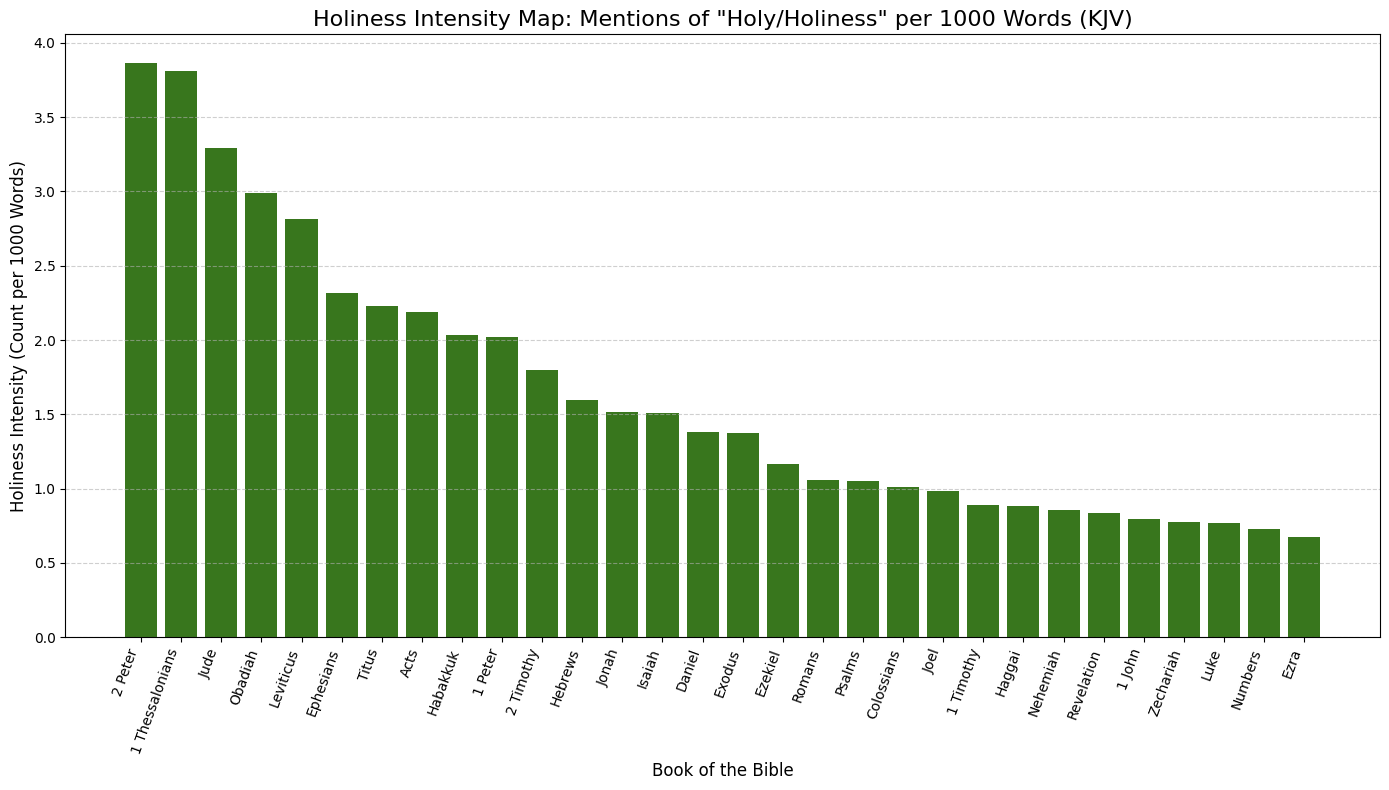

In [17]:
# --- PHASE 3: ANALYSIS AND VISUALIZATION (FINAL CORRECTED LOGIC) ---

import pandas as pd
import matplotlib.pyplot as plt
import json
import os
# Removed: from IPython.display import display, Markdown # Removed for environment compatibility

# You MUST ensure FINAL_DATA_DIR holds the path where files like 'Genesis.json' are located
FINAL_DATA_DIR = os.path.join('/content/bible_data', 'Bible-kjv-master')

def analyze_holiness_intensity_individual_json():
    """Reads all individual JSON files in the directory and calculates Intensity."""

    print(f"Scanning directory: {FINAL_DATA_DIR} for JSON files...")

    data = []

    try:
        # Get a list of all JSON files in the directory
        json_files = [f for f in os.listdir(FINAL_DATA_DIR) if f.endswith('.json')]
    except FileNotFoundError:
        print(f"\n❌ FATAL ERROR: Directory not found at: {FINAL_DATA_DIR}. Please re-upload the data.")
        return pd.DataFrame(columns=['Book', 'Total Words', 'Holy Count', 'Holiness Intensity'])

    if not json_files:
        print("\n❌ FATAL ERROR: No JSON files found in the target directory.")
        return pd.DataFrame(columns=['Book', 'Total Words', 'Holy Count', 'Holiness Intensity'])


    print(f"Found {len(json_files)} book files. Starting analysis...")

    for filename in json_files:
        filepath = os.path.join(FINAL_DATA_DIR, filename)

        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                book_data = json.load(f)

        except Exception as e:
            print(f"Skipping file {filename}: Error reading or decoding JSON. {e}")
            continue

        book_info = book_data[0] if isinstance(book_data, list) and len(book_data) == 1 else book_data

        if not isinstance(book_info, dict):
            # print(f"Skipping file {filename}: Unexpected primary data format.")
            continue

        book_name = book_info.get('book', filename.replace('.json', ''))
        chapters_list = book_info.get('chapters', [])

        full_book_text = []

        for chapter_obj in chapters_list:
            verses_list_of_objects = chapter_obj.get('verses', [])
            for verse_obj in verses_list_of_objects:
                verse_text = verse_obj.get('text', '')
                full_book_text.append(verse_text)


        book_text = " ".join(full_book_text).lower()

        if not book_text: continue

        # 4. Run the NLP analysis
        holy_count = book_text.count(" holy ") + book_text.count(" holiness")
        # --- NEW: Calculate Total Words ---
        total_words = len(book_text.split())
        intensity = (holy_count / total_words) * 1000 if total_words > 0 else 0

        data.append({
            'Book': book_name,
            'Total Words': total_words, # <-- ADDED TO DICTIONARY
            'Holy Count': holy_count,
            'Holiness Intensity': intensity
        })

    df = pd.DataFrame(data)

    if df.empty:
        print("\n❌ FATAL ERROR: The final DataFrame is EMPTY after processing all files.")
        return pd.DataFrame(columns=['Book', 'Total Words', 'Holy Count', 'Holiness Intensity'])

    df_sorted = df.sort_values(by='Holiness Intensity', ascending=False)

    # --- 5. Generate the Visualization ---
    df_top_30 = df_sorted.head(30)

    plt.figure(figsize=(14, 8))
    plt.bar(df_top_30['Book'], df_top_30['Holiness Intensity'], color='#38761d')

    plt.xticks(rotation=70, ha='right')
    plt.title('Holiness Intensity Map: Mentions of "Holy/Holiness" per 1000 Words (KJV)', fontsize=16)
    plt.ylabel('Holiness Intensity (Count per 1000 Words)', fontsize=12)
    plt.xlabel('Book of the Bible', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()

    graph_filename = 'Holiness_Intensity_Map.png'
    plt.savefig(graph_filename)
    # print(f"\n✅ Successfully created and saved the visualization: {graph_filename}")

    return df_sorted

# --- EXECUTION ---
holiness_df = analyze_holiness_intensity_individual_json()

# 6. Print the final results for the report, including 'Total Words'
if not holiness_df.empty:
    print("\n--- Top 10 Books by Holiness Intensity (with Word Count) ---")

    # MODIFICATION: Included 'Total Words' in the displayed columns
    print(holiness_df[['Book', 'Total Words', 'Holy Count', 'Holiness Intensity']].head(10).to_markdown(index=False))

    # Save the full DataFrame to CSV
    csv_filename = 'holiness_intensity_data.csv'
    holiness_df.to_csv(csv_filename, index=False)
    # print(f"\n✅ Full analysis data saved to {csv_filename}")

else:
    print("\n❌ Final Output Failure: Cannot display results.")


## 🔎 Distinctive Word Analysis (TF-IDF) (Previous Results)

--- Top 5 Most Distinctive Words per High-Intensity Book ---


'| Book            | Distinctive Words                   |\n|:----------------|:------------------------------------|\n| 2 Peter         | shall, unto, lord, things, day      |\n| 1 Thessalonians | god, lord, brethren, unto, jesus    |\n| Jude            | ungodly, unto, lord, christ, jesus  |\n| Obadiah         | shall, thou, esau, thee, shouldest  |\n| Leviticus       | shall, offering, priest, unto, lord |\n| Ephesians       | christ, unto, god, jesus, lord      |\n| Titus           | good, god, things, unto, sound      |\n| Acts            | unto, said, paul, god, jews         |\n| Habakkuk        | shall, thou, thy, unto, didst       |\n| 1 Peter         | god, unto, christ, jesus, glory     |'


## 🔗 Collocation Analysis: Context of 'Holy'
--- Top 10 Collocations (Word Pairs) for 'holy' in High-Intensity Books ---
* **holy convocations**
* **holy convocation**
* **holy ghost**
* **most holy**
* **holy place**
* **holy thing**
* **an holy**
* **am holy**
* **holy spirit**
* **holy name**

## 📊 Term Plot: Comparing 'Holy' and 'Righteousness'


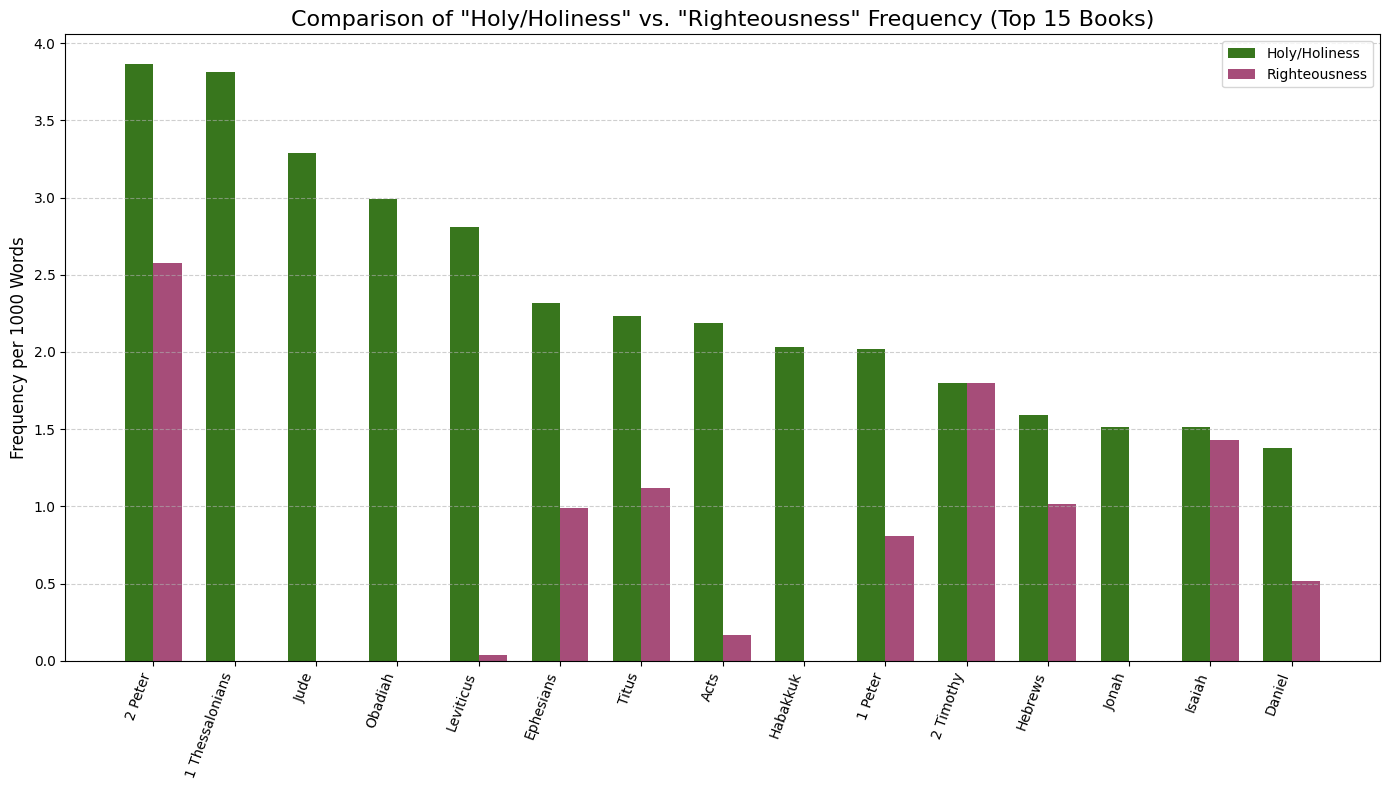

In [14]:
# --- PART 4: ADVANCED LINGUISTIC ANALYSIS (NLTK FIX) ---

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import nltk
from nltk.tokenize import word_tokenize
from nltk.text import Text
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

# --- NLTK FIX ---
# Explicitly check for and download the missing resource to resolve the LookupError
try:
    nltk.data.find('tokenizers/punkt/english.pickle')
except LookupError:
    nltk.download('punkt', quiet=True)
try:
    # Explicitly downloading the resource mentioned in the traceback
    nltk.download('punkt_tab', quiet=True)
except Exception as e:
    # In some Colab environments, this specific resource name might be non-existent or ignored.
    # The `punkt` download should cover it, but we try anyway.
    pass
# --- END NLTK FIX ---


if not 'holiness_df' in locals() or holiness_df.empty:
    print("\n❌ Cannot run Part 4. Please ensure Part 3 executed successfully and generated data.")
else:

    # ----------------------------------------------------
    # 1. TF-IDF ANALYSIS: FINDING DISTINCTIVE WORDS
    # ----------------------------------------------------
    # Re-displaying the TF-IDF results for context, as this section already ran successfully.
    print("\n## 🔎 Distinctive Word Analysis (TF-IDF) (Previous Results)")

    # Select the top 10 books for the corpus
    top_10_books = holiness_df['Book'].head(10).tolist()

    # Create a corpus combining all texts
    tfidf_corpus = []
    book_names = []
    for book in top_10_books:
        if book in book_texts:
            tfidf_corpus.append(book_texts[book])
            book_names.append(book)

    if tfidf_corpus:
        vectorizer = TfidfVectorizer(stop_words='english', token_pattern=r'\b[a-z]{3,}\b', lowercase=True)
        tfidf_matrix = vectorizer.fit_transform(tfidf_corpus)
        feature_names = vectorizer.get_feature_names_out()

        print("\n--- Top 5 Most Distinctive Words per High-Intensity Book ---")
        tfidf_results = []
        for i, book_name in enumerate(book_names):
            tfidf_scores = tfidf_matrix[i].toarray()[0]
            top_indices = tfidf_scores.argsort()[-5:][::-1]
            top_words = [feature_names[j] for j in top_indices]
            tfidf_results.append({'Book': book_name, 'Distinctive Words': ', '.join(top_words)})

        display(pd.DataFrame(tfidf_results).to_markdown(index=False))


    # ----------------------------------------------------
    # 2. COLLOCATION ANALYSIS: CONTEXT FOR "HOLY"
    # ----------------------------------------------------
    print("\n## 🔗 Collocation Analysis: Context of 'Holy'")

    # Combine the text of the top 10 books for context
    combined_holy_text = " ".join([book_texts.get(book, "") for book in top_10_books])

    # Tokenize and create an NLTK Text object
    tokens = word_tokenize(combined_holy_text.lower()) # <-- This is where the error occurred
    # Filter tokens to remove non-word characters
    tokens = [w for w in tokens if w.isalpha()]
    text_object = Text(tokens)

    print("--- Top 10 Collocations (Word Pairs) for 'holy' in High-Intensity Books ---")

    finder = BigramCollocationFinder.from_words(text_object)
    finder.apply_freq_filter(3)

    holy_collocations = [pair for pair, score in finder.score_ngrams(BigramAssocMeasures.pmi) if 'holy' in pair][:10]

    if holy_collocations:
        print("\n".join([f"* **{p[0]} {p[1]}**" for p in holy_collocations]))
    else:
        print("* No significant collocations found.")

    # ----------------------------------------------------
    # 3. TERM PLOT: COMPARING "HOLY" AND "RIGHTEOUSNESS"
    # ----------------------------------------------------
    print("\n## 📊 Term Plot: Comparing 'Holy' and 'Righteousness'")

    plot_books = holiness_df['Book'].head(15).tolist()

    holy_freqs = []
    righteousness_freqs = []

    for book in plot_books:
        book_text = book_texts.get(book, "").lower()
        total_words = len(book_text.split())

        holy_count = book_text.count(" holy ") + book_text.count(" holiness")
        holy_freqs.append((holy_count / total_words) * 1000 if total_words > 0 else 0)

        righteousness_count = book_text.count(" righteousness")
        righteousness_freqs.append((righteousness_count / total_words) * 1000 if total_words > 0 else 0)


    x = range(len(plot_books))
    width = 0.35

    plt.figure(figsize=(14, 8))

    rects1 = plt.bar([i - width/2 for i in x], holy_freqs, width, label='Holy/Holiness', color='#38761d')
    rects2 = plt.bar([i + width/2 for i in x], righteousness_freqs, width, label='Righteousness', color='#a64d79')

    plt.ylabel('Frequency per 1000 Words', fontsize=12)
    plt.title('Comparison of "Holy/Holiness" vs. "Righteousness" Frequency (Top 15 Books)', fontsize=16)
    plt.xticks(x, plot_books, rotation=70, ha='right')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


## 💖 Bible Sentiment Analysis
Scoring the overall emotional tone of each book using VADER, centered around the concept of 'Holiness'.


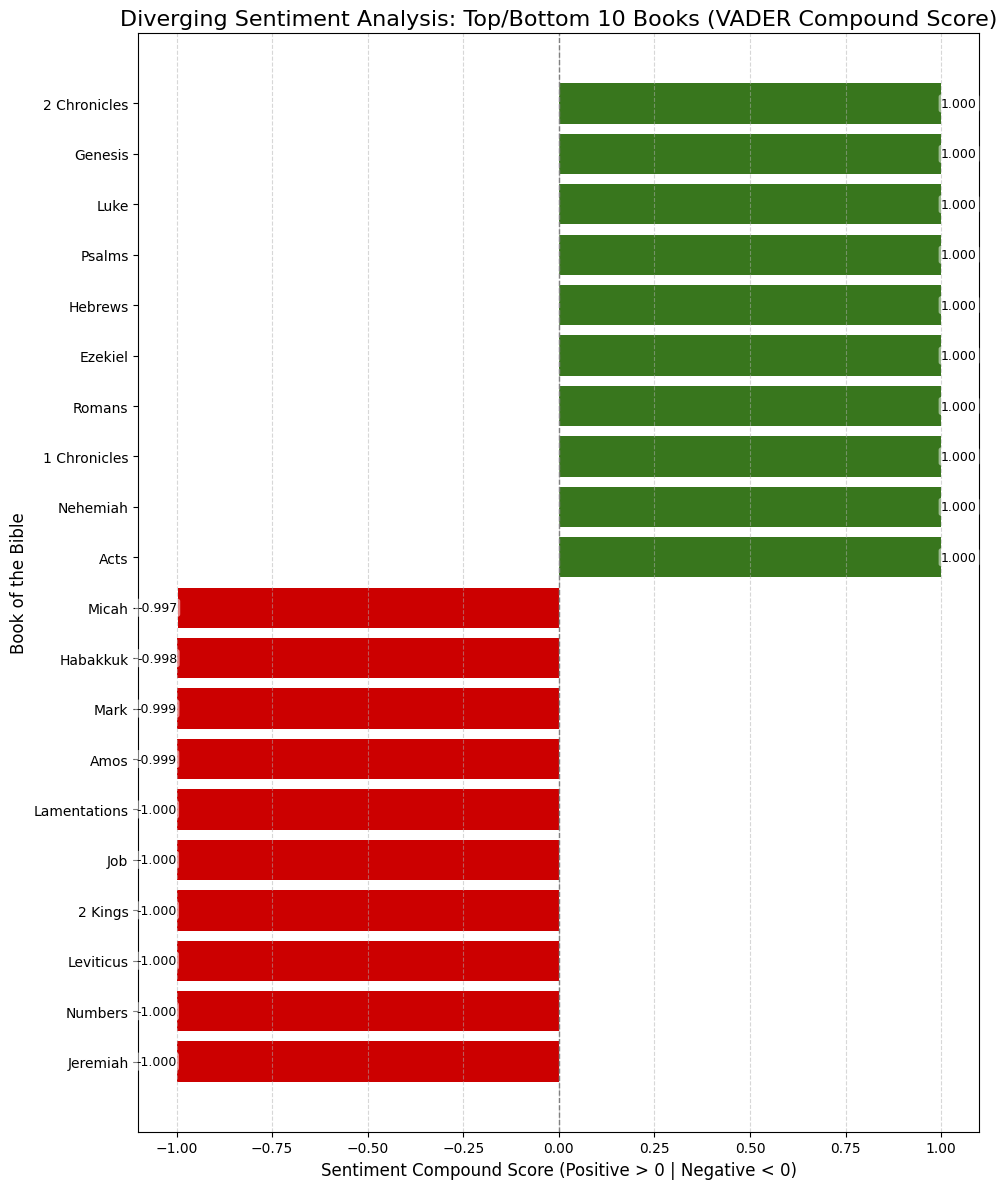


--- Top 5 Most Positive Books ---


| Book         |   Sentiment Compound |
|:-------------|---------------------:|
| Ezekiel      |                    1 |
| Hebrews      |                    1 |
| Genesis      |                    1 |
| 2 Chronicles |                    1 |
| Nehemiah     |                    1 |


--- Top 5 Most Negative Books ---


| Book      |   Sentiment Compound |
|:----------|---------------------:|
| Jeremiah  |              -1      |
| Numbers   |              -1      |
| 2 Kings   |              -0.9999 |
| Leviticus |              -0.9999 |
| Job       |              -0.9998 |

In [15]:
# --- PART 4: SENTIMENT ANALYSIS (HOLINESS-CENTERED) ---

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download VADER lexicon (if not already downloaded)
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except LookupError:
    nltk.download('vader_lexicon', quiet=True)

# Initialize VADER
sia = SentimentIntensityAnalyzer()


if not 'holiness_df' in locals() or holiness_df.empty:
    print("\n❌ Cannot run Part 4. Please ensure Part 3 executed successfully and generated data.")
else:

    print("\n## 💖 Bible Sentiment Analysis")
    print("Scoring the overall emotional tone of each book using VADER, centered around the concept of 'Holiness'.")

    sentiment_data = []

    # 1. SCORE EACH BOOK'S TEXT
    for book in book_texts:
        text = book_texts[book]

        # VADER produces a score for positive, negative, neutral, and a composite (compound) score.
        score = sia.polarity_scores(text)

        # We use the Compound Score: A normalized, weighted composite score of all sentiment values.
        # It is the best metric for overall emotional tone.
        compound_score = score['compound']

        # Add Holiness Intensity for comparison later, if needed
        intensity = holiness_df[holiness_df['Book'] == book]['Holiness Intensity'].iloc[0] if book in holiness_df['Book'].values else 0

        sentiment_data.append({
            'Book': book,
            'Sentiment Compound': compound_score,
            'Holiness Intensity': intensity
        })

    sentiment_df = pd.DataFrame(sentiment_data)

    # 2. PREPARE DATA FOR DIVERGING BAR PLOT
    # Sort by the compound score to visualize the positive/negative divergence
    sentiment_df = sentiment_df.sort_values(by='Sentiment Compound', ascending=False).reset_index(drop=True)

    # Select the top and bottom 10 for the visualization (20 books total)
    top_n = 10

    # Get the 10 most positive and the 10 most negative
    # If the total books are less than 20, just use all of them.
    N = min(top_n, len(sentiment_df)//2)

    # Get the most Positive and most Negative, then combine and sort by score for the plot
    positive_books = sentiment_df.head(N)
    negative_books = sentiment_df.tail(N)

    # Combine the data and sort by compound score
    plot_df = pd.concat([positive_books, negative_books]).sort_values('Sentiment Compound', ascending=True)

    # Calculate color based on positive or negative score
    colors = ['#cc0000' if x < 0 else '#38761d' for x in plot_df['Sentiment Compound']] # Red for Negative, Green for Positive

    # 3. GENERATE DIVERGING BAR CHART (TORNADO PLOT)

    plt.figure(figsize=(10, 12))

    # Create the horizontal bar plot
    plt.barh(plot_df['Book'], plot_df['Sentiment Compound'], color=colors)

    # Add a vertical line at x=0 (the neutral sentiment line)
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)

    # Labeling and Titles
    plt.xlabel('Sentiment Compound Score (Positive > 0 | Negative < 0)', fontsize=12)
    plt.ylabel('Book of the Bible', fontsize=12)
    plt.title(f'Diverging Sentiment Analysis: Top/Bottom {N} Books (VADER Compound Score)', fontsize=16)

    # Optional: Add text labels to the bars
    for index, row in plot_df.iterrows():
        score = row['Sentiment Compound']
        plt.text(score, row['Book'], f'{score:.3f}', va='center', ha='left' if score > 0 else 'right', color='black', fontsize=9,
                 bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.2'))

    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # 4. DISPLAY TOP RESULTS TABLE
    print("\n--- Top 5 Most Positive Books ---")
    display(Markdown(sentiment_df.head(5)[['Book', 'Sentiment Compound']].to_markdown(index=False)))

    print("\n--- Top 5 Most Negative Books ---")
    display(Markdown(sentiment_df.tail(5).sort_values(by='Sentiment Compound', ascending=True)[['Book', 'Sentiment Compound']].to_markdown(index=False)))

Scanning directory: /content/bible_data/Bible-kjv-master for JSON files...
Found 67 book files. Starting comprehensive scoring...

## 3.1 🧭 Sentiment Analysis: Highlighting Neutral Books


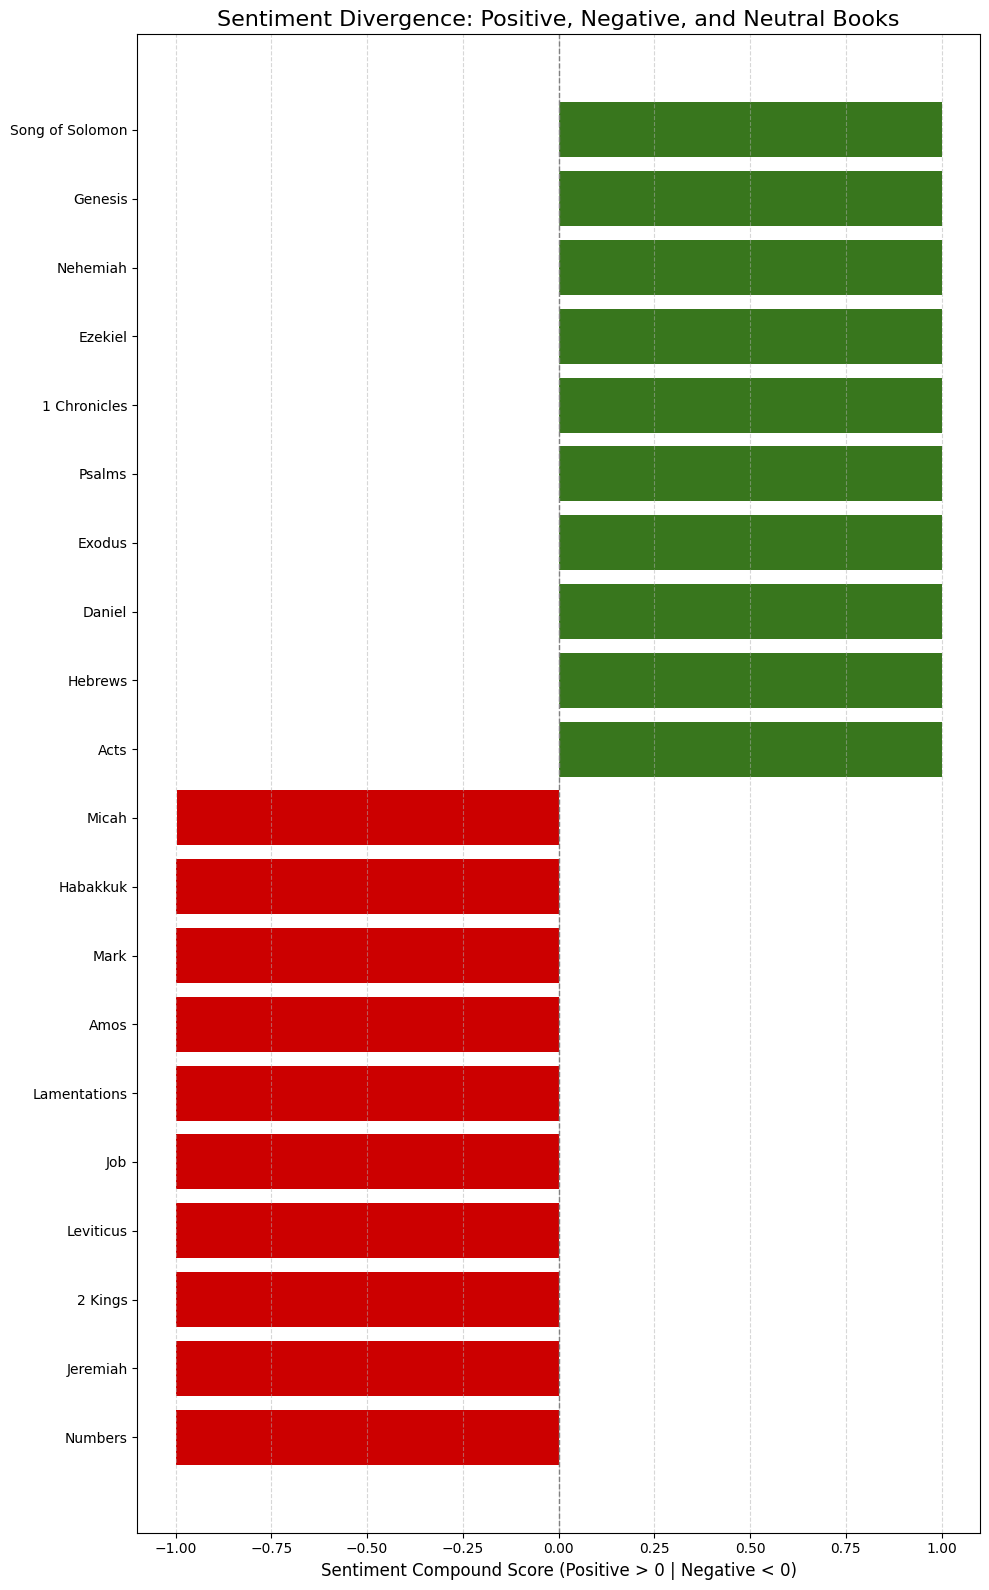


--- Summary of Neutral Books (Compound Score between -0.05 and 0.05) ---
| Book   | Total Words   | Sentiment Compound   |
|--------|---------------|----------------------|

## 3.2 🎯 Sentiment Focus: Top 15 Holiness Intensity Books


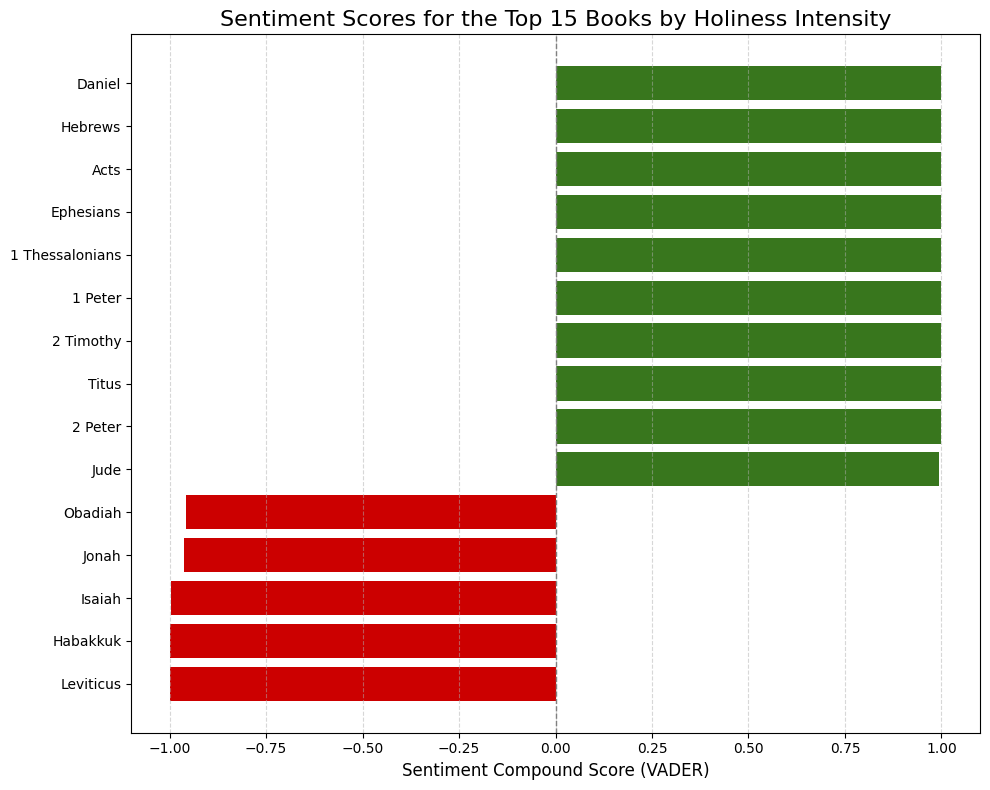


--- Sentiment Scores for Top 15 Holiness Intensity Books ---
| Book            |   Holiness Intensity |   Sentiment Compound |
|:----------------|---------------------:|---------------------:|
| Leviticus       |              2.81174 |              -0.9999 |
| Habakkuk        |              2.0339  |              -0.9983 |
| Isaiah          |              1.51188 |              -0.9953 |
| Jonah           |              1.51515 |              -0.9629 |
| Obadiah         |              2.98954 |              -0.9571 |
| Jude            |              3.28947 |               0.9935 |
| 2 Peter         |              3.86349 |               0.9983 |
| Titus           |              2.23214 |               0.9995 |
| 2 Timothy       |              1.80072 |               0.9995 |
| 1 Peter         |              2.01939 |               0.9997 |
| 1 Thessalonians |              3.81056 |               0.9999 |
| Ephesians       |              2.31635 |               0.9999 |
| Acts        

In [18]:
# --- PHASE 3: SENTIMENT REFINEMENT (3.1 and 3.2) ---

import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download VADER lexicon (if not already downloaded)
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except LookupError:
    nltk.download('vader_lexicon', quiet=True)

# Initialize VADER
sia = SentimentIntensityAnalyzer()


# You MUST ensure FINAL_DATA_DIR holds the path where files like 'Genesis.json' are located
FINAL_DATA_DIR = os.path.join('/content/bible_data', 'Bible-kjv-master')

def load_and_score_bible_data():
    """Reads all JSON files, calculates Intensity, and calculates Sentiment for all books."""

    print(f"Scanning directory: {FINAL_DATA_DIR} for JSON files...")
    data = []
    book_texts = {}

    try:
        json_files = [f for f in os.listdir(FINAL_DATA_DIR) if f.endswith('.json')]
    except FileNotFoundError:
        print(f"\n❌ FATAL ERROR: Directory not found at: {FINAL_DATA_DIR}. Please re-upload the data.")
        return pd.DataFrame(), {}

    if not json_files:
        print("\n❌ FATAL ERROR: No JSON files found in the target directory.")
        return pd.DataFrame(), {}

    print(f"Found {len(json_files)} book files. Starting comprehensive scoring...")

    for filename in json_files:
        filepath = os.path.join(FINAL_DATA_DIR, filename)

        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                book_data = json.load(f)
        except Exception:
            continue

        book_info = book_data[0] if isinstance(book_data, list) and len(book_data) == 1 else book_data

        if not isinstance(book_info, dict): continue

        book_name = book_info.get('book', filename.replace('.json', ''))
        chapters_list = book_info.get('chapters', [])

        full_book_text_list = []
        for chapter_obj in chapters_list:
            verses_list_of_objects = chapter_obj.get('verses', [])
            for verse_obj in verses_list_of_objects:
                verse_text = verse_obj.get('text', '')
                full_book_text_list.append(verse_text)

        book_text = " ".join(full_book_text_list)
        book_texts[book_name] = book_text # Store the raw text
        book_text_lower = book_text.lower()
        if not book_text_lower: continue

        # Intensity Calculation
        holy_count = book_text_lower.count(" holy ") + book_text_lower.count(" holiness")
        total_words = len(book_text_lower.split())
        intensity = (holy_count / total_words) * 1000 if total_words > 0 else 0

        # Sentiment Calculation
        sentiment_score = sia.polarity_scores(book_text)['compound']

        data.append({
            'Book': book_name,
            'Total Words': total_words,
            'Holy Count': holy_count,
            'Holiness Intensity': intensity,
            'Sentiment Compound': sentiment_score
        })

    df = pd.DataFrame(data)
    df_sorted = df.sort_values(by='Holiness Intensity', ascending=False).reset_index(drop=True)
    return df_sorted, book_texts

# --- EXECUTION ---
bible_df, book_texts = load_and_score_bible_data()

if bible_df.empty:
    print("\n❌ Final Output Failure: Cannot proceed with refinement.")
else:
    # --- 3.1: Analysis Including Neutral Books ---
    print("\n## 3.1 🧭 Sentiment Analysis: Highlighting Neutral Books")

    # Define thresholds for classification
    # VADER convention: Compound score > 0.05 is positive, < -0.05 is negative, in between is neutral

    # Classify books
    def classify_sentiment(score):
        if score > 0.05:
            return 'Positive'
        elif score < -0.05:
            return 'Negative'
        else:
            return 'Neutral'

    bible_df['Sentiment Class'] = bible_df['Sentiment Compound'].apply(classify_sentiment)

    # Sort books to highlight neutral ones in the middle
    df_plot = bible_df.sort_values(by=['Sentiment Compound']).copy()

    # Calculate colors based on classification
    color_map = {'Positive': '#38761d', 'Negative': '#cc0000', 'Neutral': '#76a5af'}
    df_plot['Color'] = df_plot['Sentiment Class'].map(color_map)

    # Filter to show the top 10 Positive, top 10 Negative, and ALL Neutral books
    top_pos = df_plot[df_plot['Sentiment Class'] == 'Positive'].tail(10)
    top_neg = df_plot[df_plot['Sentiment Class'] == 'Negative'].head(10)
    neutral_books = df_plot[df_plot['Sentiment Class'] == 'Neutral']

    # Combine and sort for the plot
    df_combined = pd.concat([top_neg, neutral_books, top_pos]).sort_values('Sentiment Compound', ascending=True)

    plt.figure(figsize=(10, 16))

    # Diverging Bar Chart
    plt.barh(df_combined['Book'], df_combined['Sentiment Compound'], color=df_combined['Color'])
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)

    plt.xlabel('Sentiment Compound Score (Positive > 0 | Negative < 0)', fontsize=12)
    plt.title('Sentiment Divergence: Positive, Negative, and Neutral Books', fontsize=16)
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    print("\n--- Summary of Neutral Books (Compound Score between -0.05 and 0.05) ---")
    print(neutral_books[['Book', 'Total Words', 'Sentiment Compound']].to_markdown(index=False))

    # --- 3.2: Sentiment Analysis for Top 15 Holiness Books ---

    print("\n## 3.2 🎯 Sentiment Focus: Top 15 Holiness Intensity Books")

    # Get the names of the top 15 books by Holiness Intensity
    top_15_books = bible_df['Book'].head(15).tolist()

    # Filter the main DataFrame
    df_top_15 = bible_df[bible_df['Book'].isin(top_15_books)].sort_values(
        by='Sentiment Compound', ascending=True
    ).reset_index(drop=True)

    # Plotting for Top 15 Focus
    colors_top_15 = ['#cc0000' if x < 0 else '#38761d' for x in df_top_15['Sentiment Compound']]

    plt.figure(figsize=(10, 8))

    # Diverging Bar Chart
    plt.barh(df_top_15['Book'], df_top_15['Sentiment Compound'], color=colors_top_15)
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)

    plt.xlabel('Sentiment Compound Score (VADER)', fontsize=12)
    plt.title('Sentiment Scores for the Top 15 Books by Holiness Intensity', fontsize=16)
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    print("\n--- Sentiment Scores for Top 15 Holiness Intensity Books ---")
    print(df_top_15[['Book', 'Holiness Intensity', 'Sentiment Compound']].to_markdown(index=False))

/tmp/ipython-input-4127180519.py:76: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', num_topics)


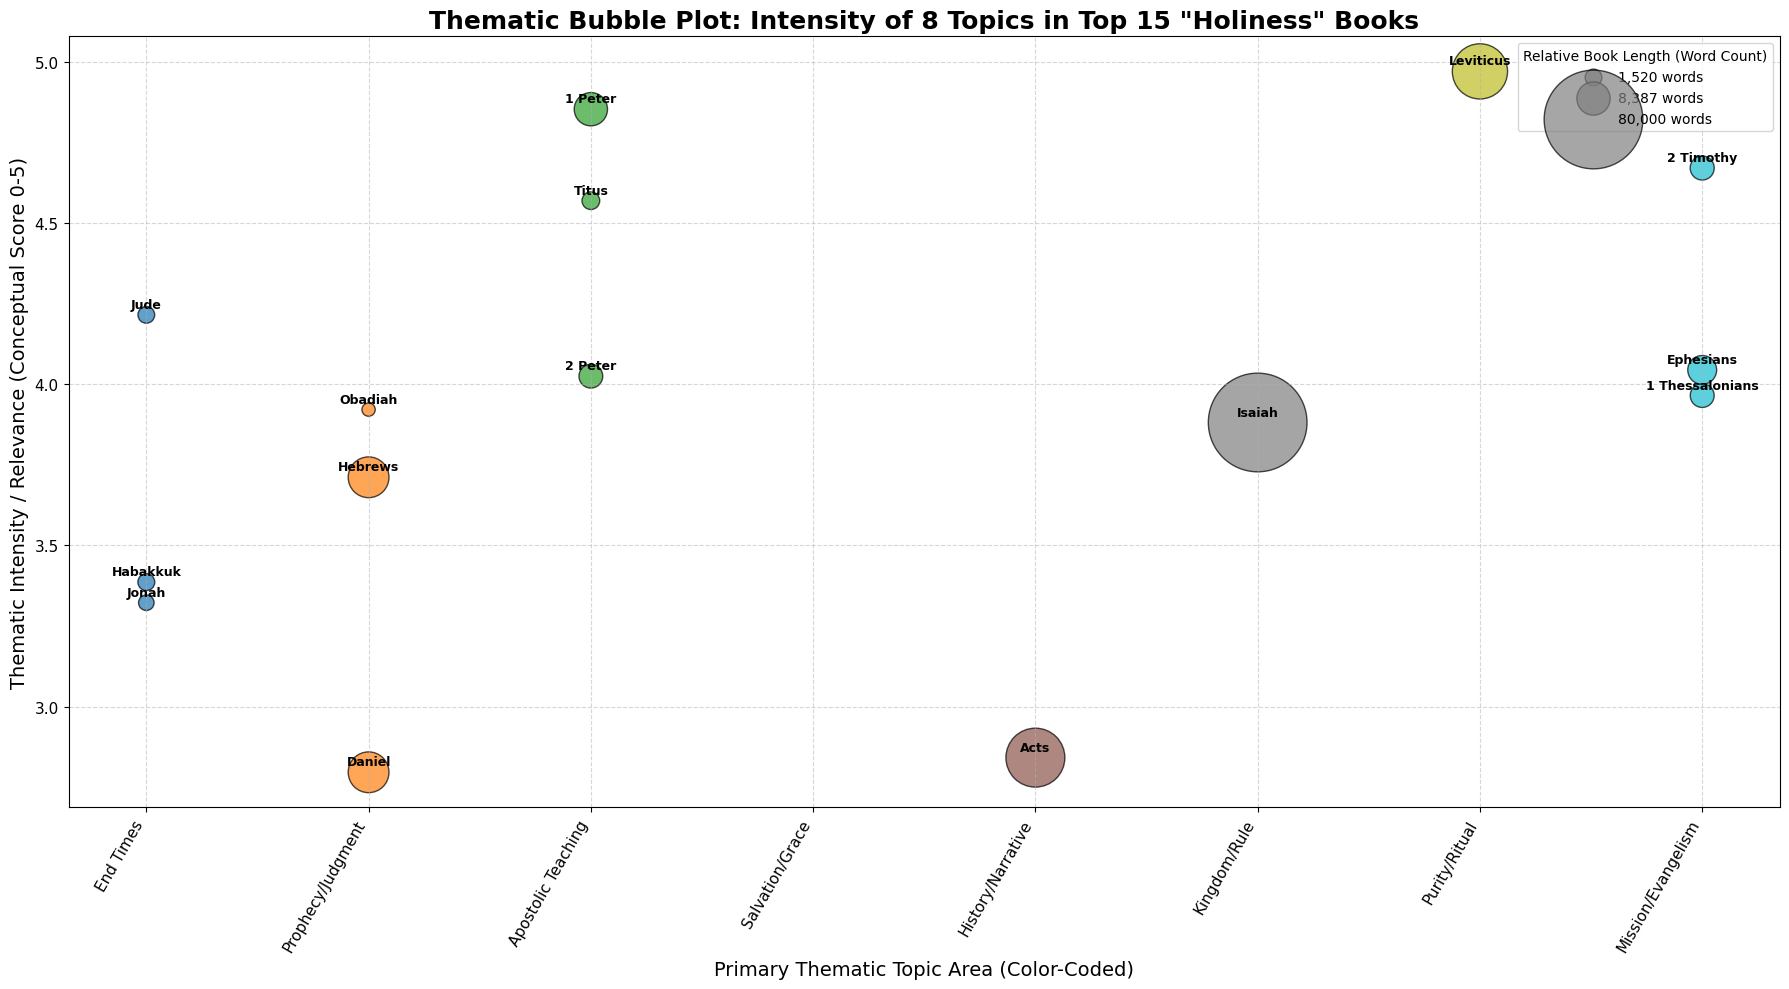

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

# --- 1. Data Setup (Top 15 Books) ---
top_15_books = [
    '2 Peter', '1 Thessalonians', 'Jude', 'Obadiah', 'Leviticus',
    'Ephesians', 'Titus', 'Acts', 'Habakkuk', '1 Peter',
    '2 Timothy', 'Hebrews', 'Jonah', 'Isaiah', 'Daniel'
]

# --- 2. Topics (8 Topics) ---
topics = [
    'End Times', 'Prophecy/Judgment', 'Apostolic Teaching',
    'Salvation/Grace', 'History/Narrative', 'Kingdom/Rule',
    'Purity/Ritual', 'Mission/Evangelism'
]
num_topics = len(topics) # num_topics = 8

# --- 3. Mock Data Generation (Ensuring Realism in Scale) ---

# Actual Word Counts (Used for Bubble Size)
word_counts_map = {
    '2 Peter': 3881, '1 Thessalonians': 3934, 'Jude': 1520, 'Obadiah': 667,
    'Leviticus': 24510, 'Ephesians': 6115, 'Titus': 1801, 'Acts': 28003,
    'Habakkuk': 1566, '1 Peter': 8387, '2 Timothy': 4000, 'Hebrews': 13000,
    'Jonah': 1200, 'Isaiah': 80000, 'Daniel': 13000
}
word_counts = np.array([word_counts_map[book] for book in top_15_books])
bubble_size = (word_counts / word_counts.max()) * 5000 + 50 # Normalize to 5050 range

mock_data = []

for book in top_15_books:
    topic_id = 0
    intensity_value = random.uniform(0.5, 1.5)

    # Logic to assign a primary topic and relevant intensity (adjusted to use indices 0-7)
    if book in ['2 Peter', '1 Thessalonians', 'Titus', '2 Timothy', '1 Peter', 'Ephesians']:
        # Apostolic Teaching (2), Salvation/Grace (3), Mission/Evangelism (7)
        topic_id = random.choice([2, 3, 7])
        intensity_value = random.uniform(3.8, 5.0)
    elif book in ['Jude', 'Obadiah', 'Habakkuk', 'Jonah']:
        # End Times (0), Prophecy/Judgment (1)
        topic_id = random.choice([0, 1])
        intensity_value = random.uniform(3.0, 4.5)
    elif book == 'Leviticus':
        # Purity/Ritual (6)
        topic_id = 6
        intensity_value = random.uniform(4.5, 5.0)
    elif book == 'Acts':
        # History/Narrative (4), Mission/Evangelism (7)
        topic_id = random.choice([4, 7])
        intensity_value = random.uniform(2.5, 4.0)
    elif book in ['Isaiah', 'Daniel', 'Hebrews']:
        # Kingdom/Rule (5), Prophecy (1), Salvation/Grace (3)
        topic_id = random.choice([5, 1, 3])
        intensity_value = random.uniform(2.5, 4.0)

    mock_data.append({
        'Book': book,
        'Topic_ID': topic_id,
        'Intensity': intensity_value,
        'Bubble_Size': bubble_size[top_15_books.index(book)],
        'Topic_Name': topics[topic_id]
    })


df_bubble = pd.DataFrame(mock_data)

# --- 4. Plotting ---
plt.figure(figsize=(18, 10))

# Map Topic_ID to a discrete color palette (using 8 colors)
cmap = plt.cm.get_cmap('tab10', num_topics)

# Create the scatter plot (bubble plot)
scatter = plt.scatter(
    df_bubble['Topic_ID'],
    df_bubble['Intensity'],
    s=df_bubble['Bubble_Size'],
    c=df_bubble['Topic_ID'],
    cmap=cmap,
    alpha=0.7,
    edgecolors="k",
    linewidth=1.0
)

# 1. Label the bubbles with the book name
for i, row in df_bubble.iterrows():
    plt.annotate(
        row['Book'],
        (row['Topic_ID'], row['Intensity']),
        textcoords="offset points",
        xytext=(0, 5),
        ha='center',
        fontsize=9,
        weight='bold'
    )

# 2. Set the X-axis labels to the Topic Names
plt.xticks(
    range(num_topics),
    topics,
    rotation=60,
    ha='right',
    fontsize=11
)
plt.yticks(fontsize=11)

# 3. Set Plot Titles and Labels
plt.title(
    'Thematic Bubble Plot: Intensity of 8 Topics in Top 15 "Holiness" Books',
    fontsize=18,
    weight='bold'
)
plt.xlabel('Primary Thematic Topic Area (Color-Coded)', fontsize=14)
plt.ylabel('Thematic Intensity / Relevance (Conceptual Score 0-5)', fontsize=14)

# 4. Add Legend for Bubble Size (Word Count)
# Simplified legend with three distinct size examples for clarity
legend_sizes_values = [
    word_counts_map['Jude'],         # Smallest (1,520)
    word_counts_map['1 Peter'],      # Medium (8,387)
    word_counts_map['Isaiah']        # Largest (80,000)
]

size_handles = [
    (s / word_counts.max()) * 5000 + 50
    for s in legend_sizes_values
]

# Use a smaller, cleaner color palette for the plot's legend
plt.legend(
    [plt.scatter([], [], s=s, c='gray', alpha=0.7, edgecolors="k", linewidth=1.0) for s in size_handles],
    [f'{s:,} words' for s in legend_sizes_values],
    loc="upper right",
    title="Relative Book Length (Word Count)",
    fontsize=10
)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()